#Classifying gene expression data by tumor type and identifying the most important genes for classification

In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

**First, we load the gene expression data and tumor type labels, aligning them by sample identifiers.**

In [15]:
def load_data(expression_file, labels_file):
    data = np.genfromtxt(expression_file)
    data = data[:, 1:]  # Remove sample IDs

    map_sample_to_type = {}
    with open(labels_file, 'r') as file:
        file.readline()
        for line in file:
            sample, Type = line.strip().split(',', 1)
            map_sample_to_type[sample] = Type

    types = []
    with open(expression_file, 'r') as file:
        for line in file:
            sample, aux = line.split(" ", 1)
            types.append(map_sample_to_type[sample])

    return data, np.array(types)

def preprocess_types(types):
    type_mapping = {"PRAD": 0, "LUAD": 1, "BRCA": 2, "KIRC": 3, "COAD": 4}
    return np.array([type_mapping[t] for t in types])


In [16]:
expression_file = "expressions.txt"
labels_file = "tcga-pancan-hiseqlabels.csv"

# Load and preprocess data
data, types = load_data(expression_file, labels_file)
types = preprocess_types(types)

**Visualize the data using PCA to get an idea of how separable the classes are.**

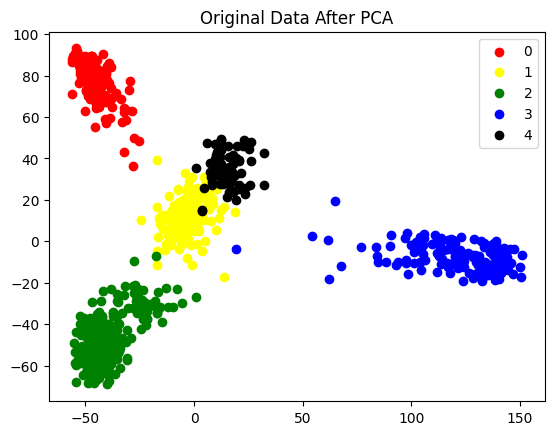

In [17]:
def visualize_pca(data, types, title):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    colors = ['red', 'yellow', 'green', 'blue', 'black']

    plt.figure()
    for t in np.unique(types):
        data_single_type = data_2d[types == t]
        plt.scatter(data_single_type[:, 0], data_single_type[:, 1], c=colors[t], label=t)
    plt.title(title)
    plt.legend()
    plt.show()

visualize_pca(data, types, "Original Data After PCA")

**Standardization of the data to ensure all features contribute equally.**

In [18]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

**Let's use a Perceptron for classification and perform hyperparameter tuning using GridSearchCV.**

In [19]:
# Split data into training and testing sets
dataTrain, dataTest, typeTrain, typeTest = train_test_split(data, types, test_size=0.2, random_state=42)

# Define the pipeline with scaling and Perceptron
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('perceptron', Perceptron())
])

# Define hyperparameters for tuning
param_grid = {
    'perceptron__max_iter': [1000, 2000, 3000],
    'perceptron__tol': [0.001, 0.0001, 0.00001],
    'perceptron__alpha': [0.0001, 0.001, 0.01]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(dataTrain, typeTrain)

# Best model
best_model = grid_search.best_estimator_

**We evaluate the best model using cross-validation and test set.**

In [20]:
# Evaluate with cross-validation
cv_scores = cross_val_score(best_model, dataTrain, typeTrain, cv=5)
print(f"Cross-validation accuracy: {np.mean(cv_scores) * 100:.2f}%")

# Evaluate on test set
typePredicted = best_model.predict(dataTest)
test_accuracy = accuracy_score(typeTest, typePredicted)
print(f"Test set accuracy: {test_accuracy * 100:.2f}%")

print("Classification Report:\n", classification_report(typeTest, typePredicted))
print("Confusion Matrix:\n", confusion_matrix(typeTest, typePredicted))

Cross-validation accuracy: 99.84%
Test set accuracy: 99.37%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        34
           2       1.00      0.98      0.99        61
           3       1.00      1.00      1.00        22
           4       0.93      1.00      0.97        14

    accuracy                           0.99       159
   macro avg       0.99      1.00      0.99       159
weighted avg       0.99      0.99      0.99       159

Confusion Matrix:
 [[28  0  0  0  0]
 [ 0 34  0  0  0]
 [ 0  0 60  0  1]
 [ 0  0  0 22  0]
 [ 0  0  0  0 14]]


**To analyze which genes are most important for classification.**

In [21]:
def analyze_gene_importance_and_accuracy(model, dataTrain, dataTest, typeTrain, typeTest):
    model.named_steps['perceptron'].fit(dataTrain, typeTrain)  # Fit the model on the entire training set
    weights = model.named_steps['perceptron'].coef_
    important_genes = np.argsort(np.abs(weights), axis=1)[:, ::-1]  # Sort by absolute value of weights

    results = []
    for t in range(5):
        # One-vs-rest classification for tumor type `t`
        typeTrain_binary = (typeTrain == t).astype(int)
        typeTest_binary = (typeTest == t).astype(int)

        predictions_binary = (model.named_steps['perceptron'].predict(dataTest) == t).astype(int)
        accuracy = accuracy_score(typeTest_binary, predictions_binary) * 100
        results.append((t, accuracy))

    return important_genes, results

important_genes, tumor_accuracies = analyze_gene_importance_and_accuracy(best_model, dataTrain, dataTest, typeTrain, typeTest)

# Print the results
for tumor, accuracy in tumor_accuracies:
    print(f"The accuracy for tumor {tumor} is {accuracy:.2f}%")
    top_genes = important_genes[tumor, :5]  # Ensure to select top 5 genes
    print(f"Important genes for tumor type {tumor}: {top_genes}")
    for gene in top_genes:
        print(f"  Gene {gene} with weight {best_model.named_steps['perceptron'].coef_[tumor, gene]:.4f}")


The accuracy for tumor 0 is 99.37%
Important genes for tumor type 0: [ 347 1689 1287 1581 1683]
  Gene 347 with weight -13.5658
  Gene 1689 with weight -13.4667
  Gene 1287 with weight -13.3463
  Gene 1581 with weight -13.1823
  Gene 1683 with weight 12.9668
The accuracy for tumor 1 is 100.00%
Important genes for tumor type 1: [1815 1423 1765 1812   71]
  Gene 1815 with weight 20.3125
  Gene 1423 with weight 20.2976
  Gene 1765 with weight 20.1922
  Gene 1812 with weight 19.7600
  Gene 71 with weight 18.8868
The accuracy for tumor 2 is 98.74%
Important genes for tumor type 2: [ 544   60 1022 2161 1100]
  Gene 544 with weight 10.2810
  Gene 60 with weight 9.9184
  Gene 1022 with weight 9.7036
  Gene 2161 with weight 9.6570
  Gene 1100 with weight 9.6427
The accuracy for tumor 3 is 100.00%
Important genes for tumor type 3: [ 777 1653 1619  422 2045]
  Gene 777 with weight 12.0991
  Gene 1653 with weight -10.7305
  Gene 1619 with weight -10.5732
  Gene 422 with weight -10.2215
  Gene 2045

**Visualize the predictions using PCA.**

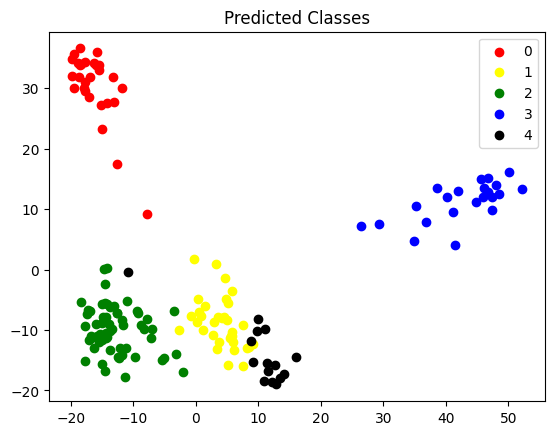

In [22]:
# Visualize predictions
visualize_pca(dataTest, typePredicted, "Predicted Classes")